<font style="Times New Roman" style="font-size:24px" color='red'> Parallel Processing of a High Resolution Surface Wind Model Data using Dask (Dask.map_blocks & Xarray)</font>
================================================================
<img src="https://upload.wikimedia.org/wikipedia/commons/8/80/Rhode_Island_Rams_logo.svg" 
     width="30%" 
     align=right
     alt="Dask logo">


This notebook shows application of dask-backed `xarray.DataArray` to parallelize the plotting of wind field from the University of Rhode Island's [Hurricane Boundary Layer Wind Model(URI-HBL)](https://ams.confex.com/ams/34HURR/meetingapp.cgi/Paper/373889) 
This program uses [dask.array.map_blocks](https://docs.dask.org/en/latest/generated/dask.array.map_blocks.html) to distribute chunks of data blocks within the wrapper.

URI-HBL is a three-dimensional model developed primarily to improve the surface wind forecast during the landfall of hurricanes. The model uses information of actual land cover characteristics to simulate the wind field over land. The model uses a vortex following moving mesh with a horizontal grid spacing of 1km x 1km and vertical resolution of 30m. The output interval of the model is every minute. The HBL model's computational architecture is based on Intel's MPI Library that allows the model to run in parallel within multiple CPU's. However, the post processing of the model data still uses C-C+ based serial programs i.e. NCL, Matlab etc.

This higher spatial and temporal resolution of model output makes it challenging to process the data efficiently within short period of time. Current post-processing of HBL's output is based on [NCAR Command Language](http://ncl.ucar.edu/) which runs on a single CPU and takes time to process the data.

This Dask based parallel program will help process the HBL's output at a faster rate and can play an important role in operational forecast of hurricane wind field by processing model outputs within a limited time frame.  

In this exercise, we are going to explore the application of Dask; particularly [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize the processing of HBL outputs. In doing so, we are going to use the following libraries: 

(a) [Dask](https://dask.org/)

(b) [Numpy](https://numpy.org/)

(c) [xarray](http://xarray.pydata.org/en/stable/)

(d) [Matplotlib](https://matplotlib.org/)

(e) [Pandas](https://pandas.pydata.org/)

(f) [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

(g) [Geocat](https://geocat.ucar.edu/)

(h) [IPython](https://ipython.org/)

(i) [FFmpeg](https://github.com/kkroening/ffmpeg-python)

(j) [graphviz](https://graphviz.org/)



### <font style="Times New Roman" style="font-size:24px"> Case Study: Hurricane Michael (2018) </font>

<img src="http://uri-hurricanes.info/michael_track.png" 
     width="45%" 
     align=right
     alt="michael-track">



This exercise will use the HBL simulated outputs for the case of Hurricane Michael (2018). We will be plotting the surface wind speed calcualted from the U and V-wind components.

Two sample datasets provided with this exercise; one for [u-wind component](http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_ucomp_30min.nc) and another one is for [v-wind component](http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_vcomp_30min.nc).

The datasets have been subsetted at 30-minutes interval for this exercise. 

[NCAR Command Language](http://ncl.ucar.edu/) took 308.241 seconds CPU time to process this data. We will experiment whether parallelization using Dask.map_blocks and Xarray DataArray  can process this data faster! 
.

.
Finally once we finish running this program using 30 workers, dask.map_blocks was able to process the same data in 70 seconds CPU time!

### <font style="Times New Roman" style="font-size:24px" color='red'> Start Dask Client and Set up Cluster </font>
   <font style="Times New Roman" style="font-size:18px" color='blue'> Client is used to view the dashboard and cluster is used to distribute the job across multiple processors</font>

In [1]:
import dask_jobqueue
import dask.distributed

cluster = dask_jobqueue.SLURMCluster(cores=1, memory='100GB',queue='lowpri')
cluster.scale(30) 
client = dask.distributed.Client(cluster)

## Create Wrapper module which will be passed to the Dask's map_blocks function.  

In [2]:
def wrapper(nparray, plot_wind, dim, block_info=None, **kwargs):
    
    import xarray as xr

    index = block_info[None]['chunk-location'][-1]
    
    coords = kwargs.get('coords')
    dims = kwargs.get('dims')
    attrs = kwargs.get('attrs')
    
    if coords:
        coords = coords.to_dataset().isel({dim: index}).coords
    
    xr_array = xr.DataArray(nparray.squeeze(),
                            dims=set(da.dims)-set([dim]),
                            coords=coords,
                            attrs=da.attrs)

    plot_wind(xr_array, index) 
    return np.nan


def sequence(da, dim, plot_wind):
     
    import dask.array as darray
    assert isinstance(da, xr.DataArray)
    
    if da.dims[-1] != dim:
        not_dim = list(set(list(da.dims)) - set([dim])) + [dim]
        da = da.transpose(*not_dim)
    assert(da.data.chunksize[-1] == 1)
    
    mapblock = darray.map_blocks(wrapper,
                               da.data,
                               drop_axis=(0,1),  
                               chunks=(1,),  
                               dtype=np.float64, 
                               dim=dim,  
                               dims=da.dims, coords=da.coords, attrs=da.attrs, 
                               plot_wind=plot_wind)
    
    return mapblock

### <font style="Times New Roman" style="font-size:24px" color='red'> Getting familiar with data </font>
   <font style="Times New Roman" style="font-size:18px" color='blue'> Datasets are stored in an OPeNDAP server </font>

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

nlat = 1100
nlon = 1100
ntime = 48

%time du = xr.open_dataset("http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_ucomp_30min.nc").isel(time=slice(None, 48))
%time dv = xr.open_dataset("http://tds.renci.org:8080/thredds/dodsC/dhs-crc-unc/HURRICANE_MICHAEL/michael_regrid_vcomp_30min.nc").isel(time=slice(None, 48))

du1 = du.u10
dv1 = dv.v10

wspd1 = np.sqrt(du1**2+dv1**2)

wspd = wspd1.rename({'lati':'lat','loni':'lon'})


wspd['lat'].attrs['long_name'] = 'latitude'
wspd['lat'].attrs['units'] = 'degrees_north'
wspd['lon'].attrs['long_name'] = 'longitude'
wspd['lon'].attrs['units'] = 'degrees_east'
wspd2 = wspd.transpose("lat", "lon", "time")
lat = wspd2['lat']
lon = wspd2['lon']


db = (xr.DataArray(np.array(wspd2), 
                  dims=['lat', 'lon', 'time'],
                  coords={'lat':wspd2['lat'], 'lon':wspd2['lon'], 'time': pd.date_range('2018-10-10 00:00:00', freq='30min', periods=ntime)})
      .chunk({'time': 1}))

db['lat'].attrs['long_name'] = 'latitude'
db['lat'].attrs['units'] = 'degrees_north'
db['lon'].attrs['long_name'] = 'longitude'
db['lon'].attrs['units'] = 'degrees_east'
da = db

CPU times: user 134 ms, sys: 17.3 ms, total: 152 ms
Wall time: 215 ms
CPU times: user 10.2 ms, sys: 743 µs, total: 11 ms
Wall time: 16.1 ms


That dataset must have `chunksize=1` on the dimension over which to animate. If our intent is to make a movie that animates in `time`, we should chunk as above

### plotting function



In [4]:
def make_plot(xr_array, index):
    
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import cartopy
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from geocat.viz import cmaps as gvcmaps
    from geocat.viz import util as gvutil
    
    f, ax = plt.subplots(1, 1, figsize=(15,12))

    projection = ccrs.PlateCarree()
    
    ax = plt.axes(projection=projection)
    plt.title("")
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.tick_params(labelsize=12)
    ax.set_title('',fontsize=12)
    gvutil.set_axes_limits_and_ticks(ax,
                                    xticks=[-100, -96, -92, -88,  -84, -80, -76],
                                    yticks=[14,  18,  22,  26,  30,  34])

    gvutil.add_lat_lon_ticklabels(ax)

    gvutil.add_major_minor_ticks(ax,
                                 x_minor_per_major=2,
                                 y_minor_per_major=2,
                                 labelsize=12)

    gvutil.set_titles_and_labels(ax,
                             maintitle=" ",
                             maintitlefontsize=14,
                             lefttitle=" ",
                             lefttitlefontsize=8,
                             righttitle="Hurricane Michael (2018)",
                             righttitlefontsize=8,
                             xlabel="Longitude",
                             ylabel="Latitude")

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines(resolution='10m', color='black', linewidth=0.25)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
    ax.coastlines(linewidths=1.5)
    ax.set_extent([-100, -78, 20, 35], crs=ccrs.PlateCarree())
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.set_extent([-90, -77, 23.5, 34.5], crs=ccrs.PlateCarree())
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.add_feature(cfeature.LAND, facecolor='white')

    
    
    
    
    # ax=ax is required!
    xr_array.plot(ax=ax,
                  vmin=0, vmax=60, cmap=mpl.cm.jet, 
                  extend='both',
                  cbar_kwargs={'orientation': 'vertical'})
    plt.xlabel('')
    plt.ylabel('')
   
    f.savefig(f"images2/{index:04d}.png", dpi=300, bbox_inches='tight')
    
    # this prevents a warning that is issued when more than 20 figures are open.
    # maybe it saves memory too?
    plt.close(f)
    del f

In [5]:
del du1
del dv1
del wspd1
del wspd
import gc; gc.collect()

40

### Call 'sequence' which will return dask array, dimension over which the loop will be executed and the plotting module

In [6]:
mapblock = sequence(da=da, dim='time', plot_wind=make_plot)
mapblock

dask.array<wrapper, shape=(48,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>

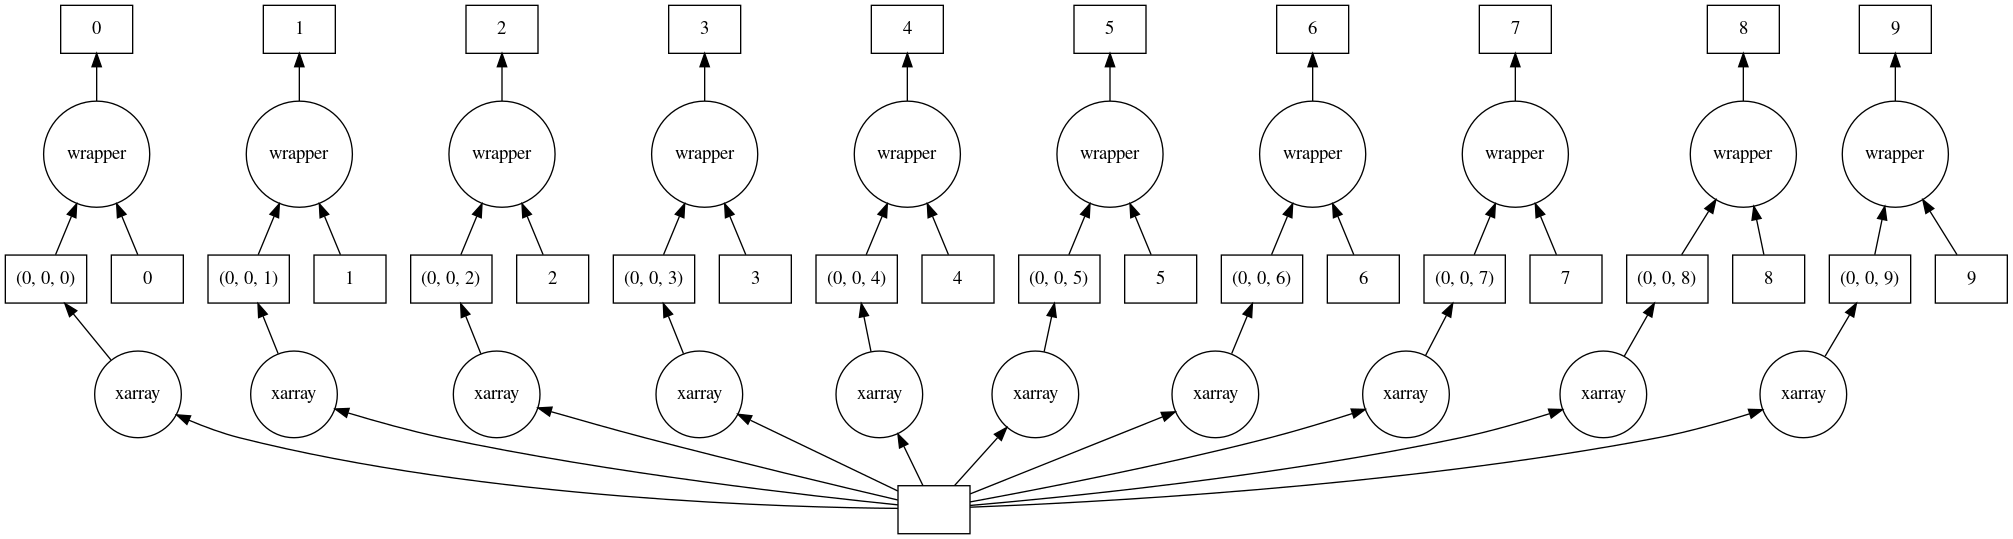

In [8]:
 mapblock.visualize()

<img src="https://static1.srcdn.com/wordpress/wp-content/uploads/2020/05/Toy-Story-Buzz-Woody.jpg" 
     width="50%" 
     align=left
     alt="Dask logo">



<font style="Times New Roman" style="font-size:36px" color='red'> Parallel Distribution !</font>
================================================================


In [7]:
%time dask.compute(mapblock[:])

CPU times: user 51.2 s, sys: 22.8 s, total: 1min 14s
Wall time: 1min 42s


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan]),)

In [8]:
cluster.close()
client.close()

### <font style="Times New Roman" style="font-size:24px" color='red'> Let's check the number of output files. </font>
   <font style="Times New Roman" style="font-size:18px" color='blue'> It should be 48 since variable 'time' has length of 48 and we are plotting for each time interval</font>

In [9]:
!ls $PWD/images2 | wc -l                 #bash command to check number of files

48


In [10]:
ls -alh images2/                         #list the output files


total 46M
drwxr-sr-x 2 mjisan storage-dhs-crc 1.3K Dec  8 11:47 ./
drwxr-sr-x 7 mjisan storage-dhs-crc 3.0K Dec  9 11:36 ../
-rw-r--r-- 1 mjisan storage-dhs-crc 527K Dec  9 11:35 0000.png
-rw-r--r-- 1 mjisan storage-dhs-crc 664K Dec  9 11:34 0001.png
-rw-r--r-- 1 mjisan storage-dhs-crc 378K Dec  9 11:35 0002.png
-rw-r--r-- 1 mjisan storage-dhs-crc 379K Dec  9 11:35 0003.png
-rw-r--r-- 1 mjisan storage-dhs-crc 650K Dec  9 11:35 0004.png
-rw-r--r-- 1 mjisan storage-dhs-crc 651K Dec  9 11:35 0005.png
-rw-r--r-- 1 mjisan storage-dhs-crc 657K Dec  9 11:34 0006.png
-rw-r--r-- 1 mjisan storage-dhs-crc 664K Dec  9 11:35 0007.png
-rw-r--r-- 1 mjisan storage-dhs-crc 667K Dec  9 11:35 0008.png
-rw-r--r-- 1 mjisan storage-dhs-crc 671K Dec  9 11:34 0009.png
-rw-r--r-- 1 mjisan storage-dhs-crc 379K Dec  9 11:35 0010.png
-rw-r--r-- 1 mjisan storage-dhs-crc 380K Dec  9 11:35 0011.png
-rw-r--r-- 1 mjisan storage-dhs-crc 379K Dec  9 11:35 0012.png
-rw-r--r-- 1 mjisan storage-dhs-crc 671K Dec  9 11:34 00

### <font style="Times New Roman" style="font-size:24px" color='red'> Display one of the plots </font>

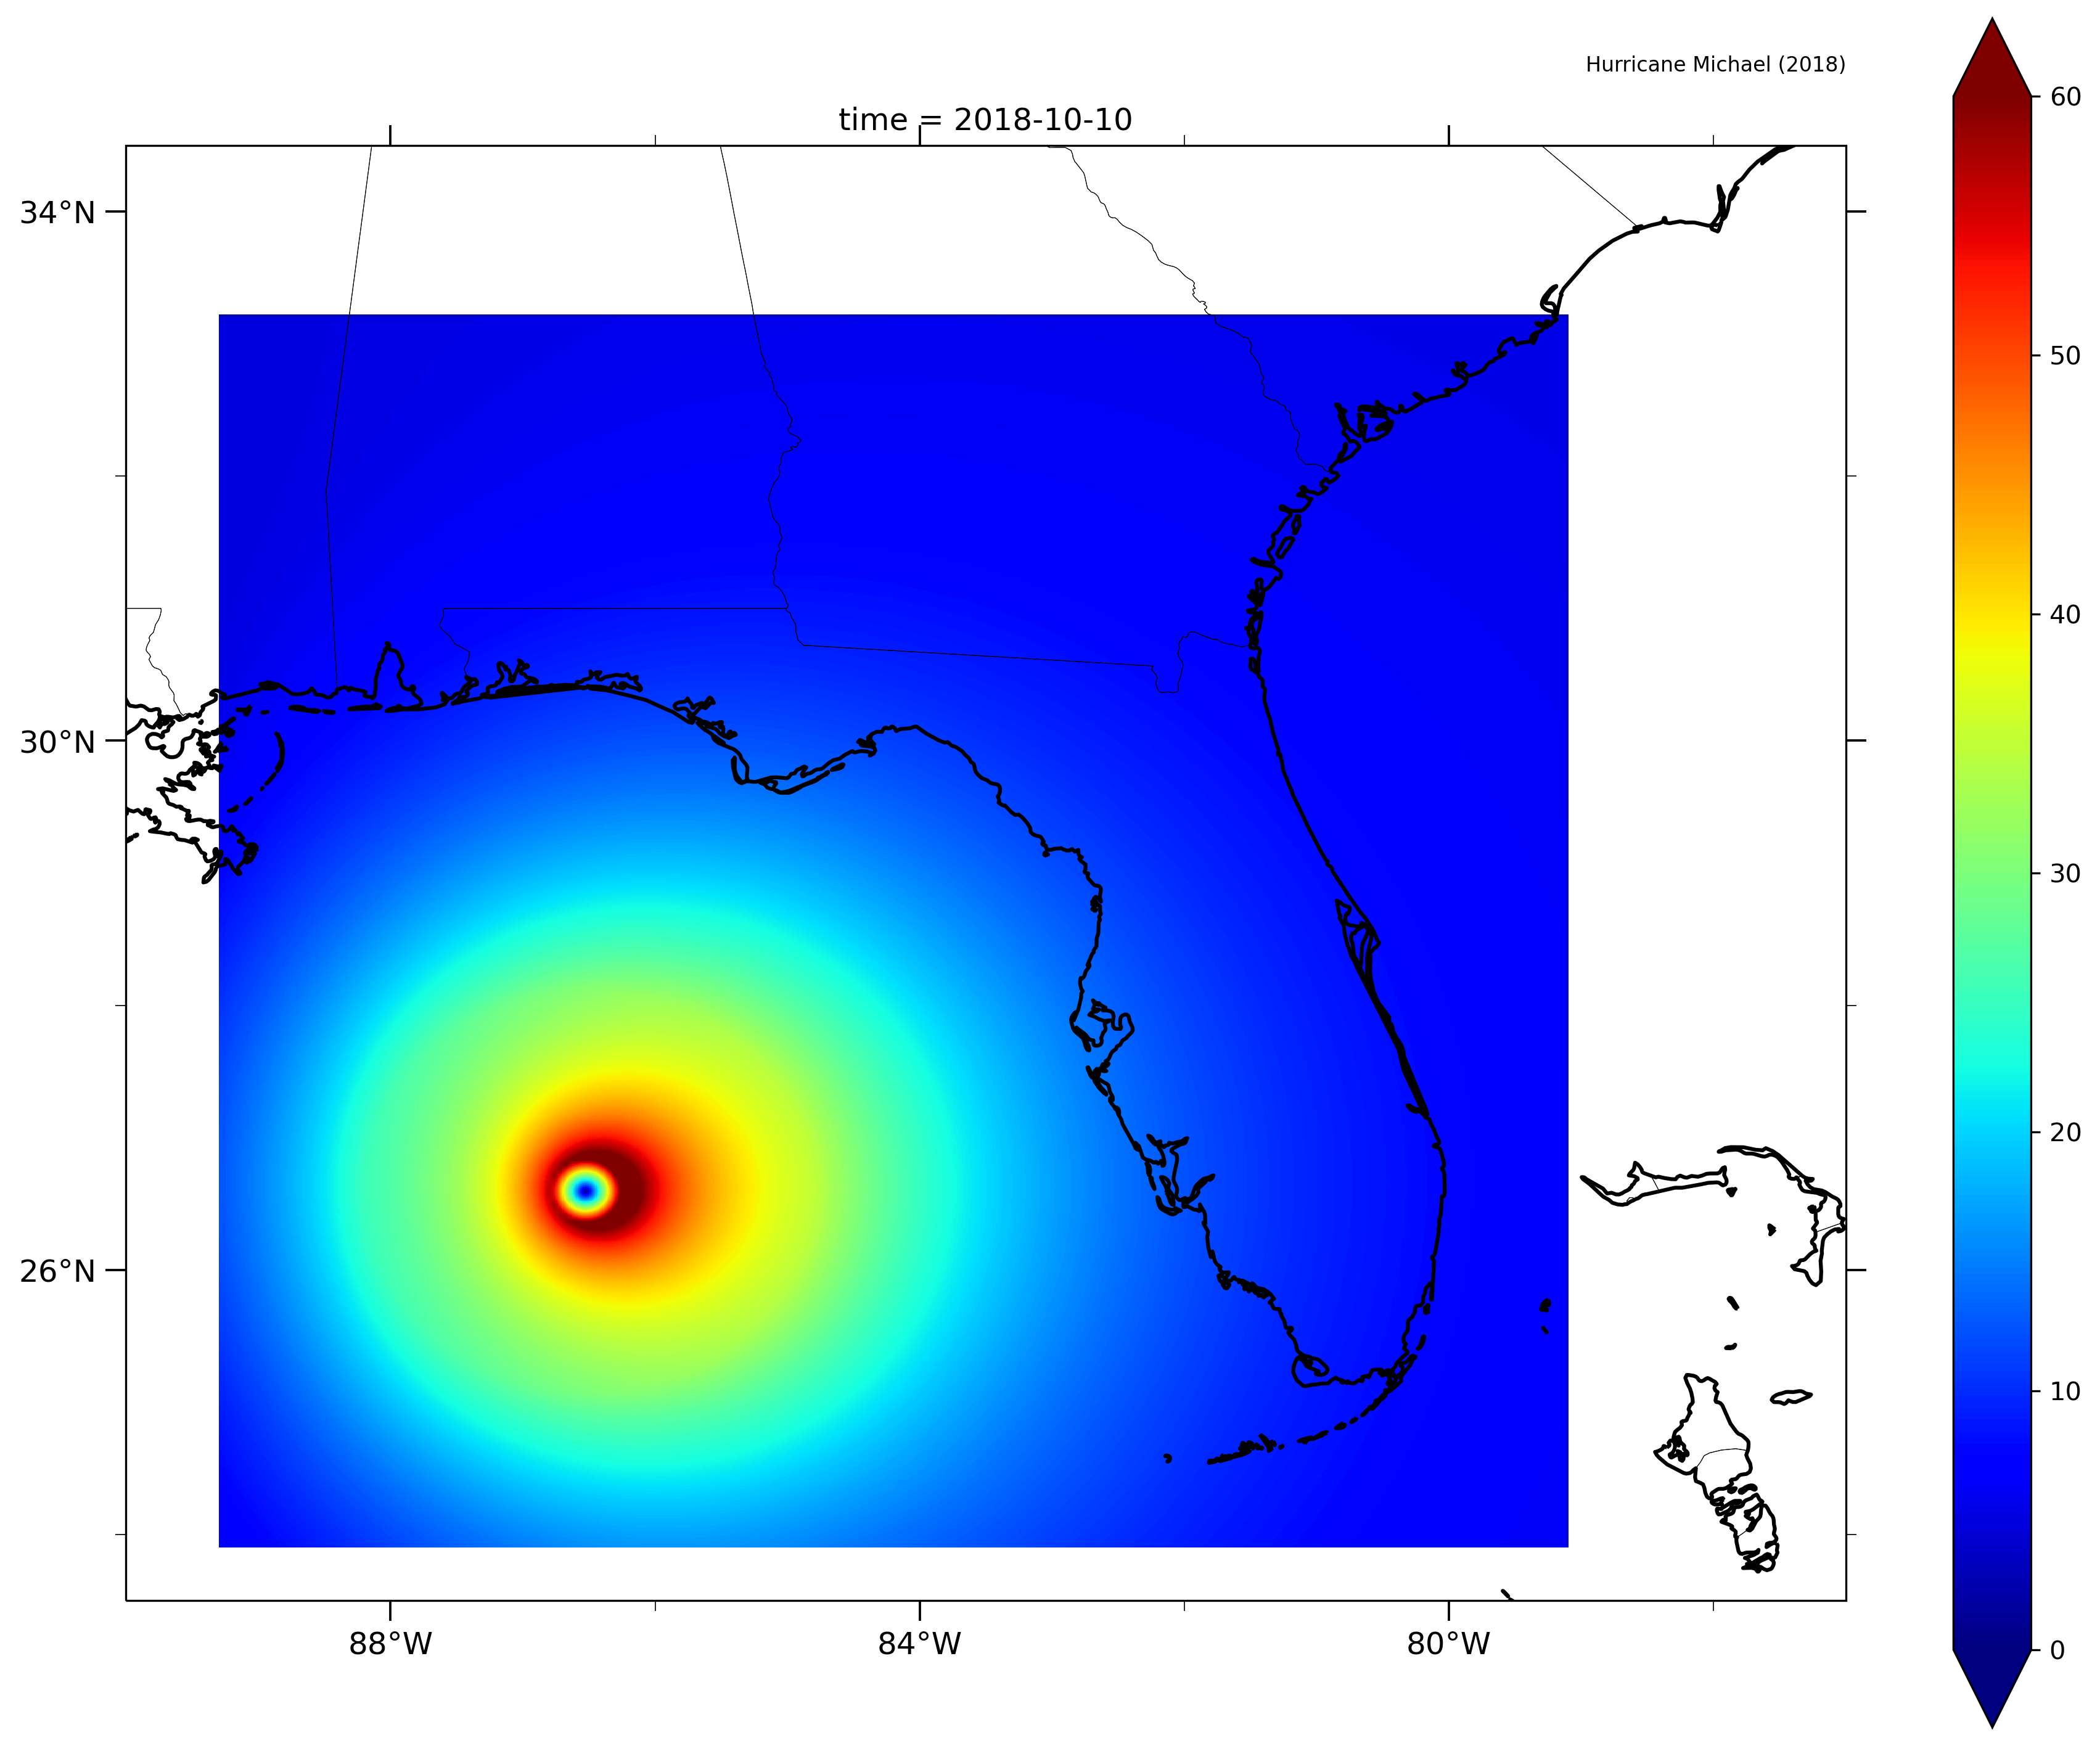

In [11]:
from IPython.display import Image
Image('images2/0000.png')

### <font style="Times New Roman" style="font-size:24px" color='red'> Use ImageMagick to make animated GIF from the sequence of PNGs </font>

In [12]:
! /usr/bin/convert -delay 14 -loop 0 /projects/ees/dhs-crc/mjisan/NCL_HBL/CTD/a11_nc_ctd/GEOCAT/FINAL_VERSIONS/images2/*.png -scale 1000x1000 animation2.gif

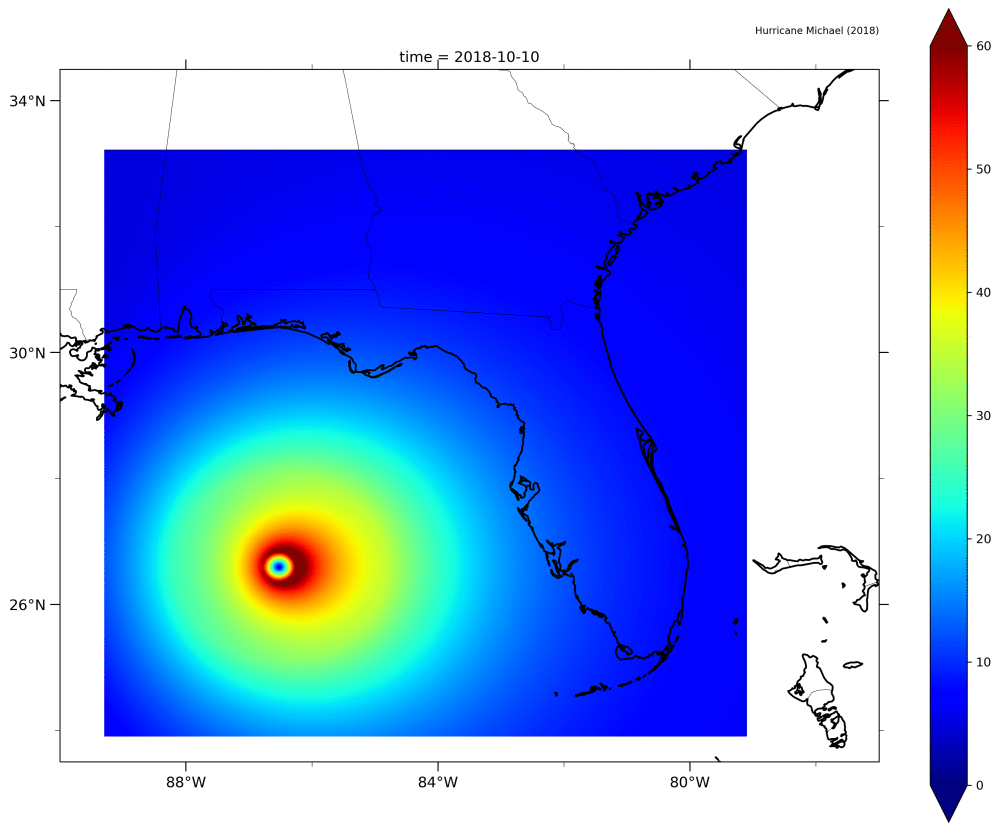

In [13]:
from IPython.display import Image

Image('animation2.gif')

<img src="http://uri-hurricanes.info/pymems.jpg" 
     width="50%" 
     align=Right
     alt="Dask logo">
     

### <font style="Times New Roman" style="font-size:24px" color='red'> Final Thoughts </font>



- The dask.map_blocks and dask parallel program helped distributing the plotting function as well as xr.DataArray within multiple CPU's which significantly reduced the processing time.


- Although this approach took slightly longer time than the dask.delayed function, it was able to distribute chunks of data within different CPU's enabling the efficient handling of large data. 

<font style="Times New Roman" style="font-size:24px" color='blue'>This simple Dask-backed xr.DataArray and plotting function works 6 times faster than the current NCL & Matlab program!</font>
================================================================



### <font style="Times New Roman" style="font-size:24px" color='red'> Acknowledgements </font>

- [Pangeo discourse forum](https://discourse.pangeo.io/)

- [Dask Social](https://docs.dask.org/en/stable/support.html)

- [Deepak Cherian's Github Repo](https://github.com/dcherian)
